## Cats vs. Penguins vs. Bears

![Bear](data/bear/bear.0.jpg) | ![Penguin](data/peng/peng.0.jpg) | ![Cat](data/cat/cat.0.jpg)
-----------------------|----------------------------|-------------------
A Bear                  | A Penguin | A Cat

In [1]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

vgg = keras.applications.VGG16(weights='imagenet',include_top=True)

2022-04-14 18:24:56.428737: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-14 18:24:56.989361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10790 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


In [2]:
def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

### Using pre-trained CNN

First, let's load the dataset, and apply the network to a few images from there:

Found 85 files belonging to 3 classes.


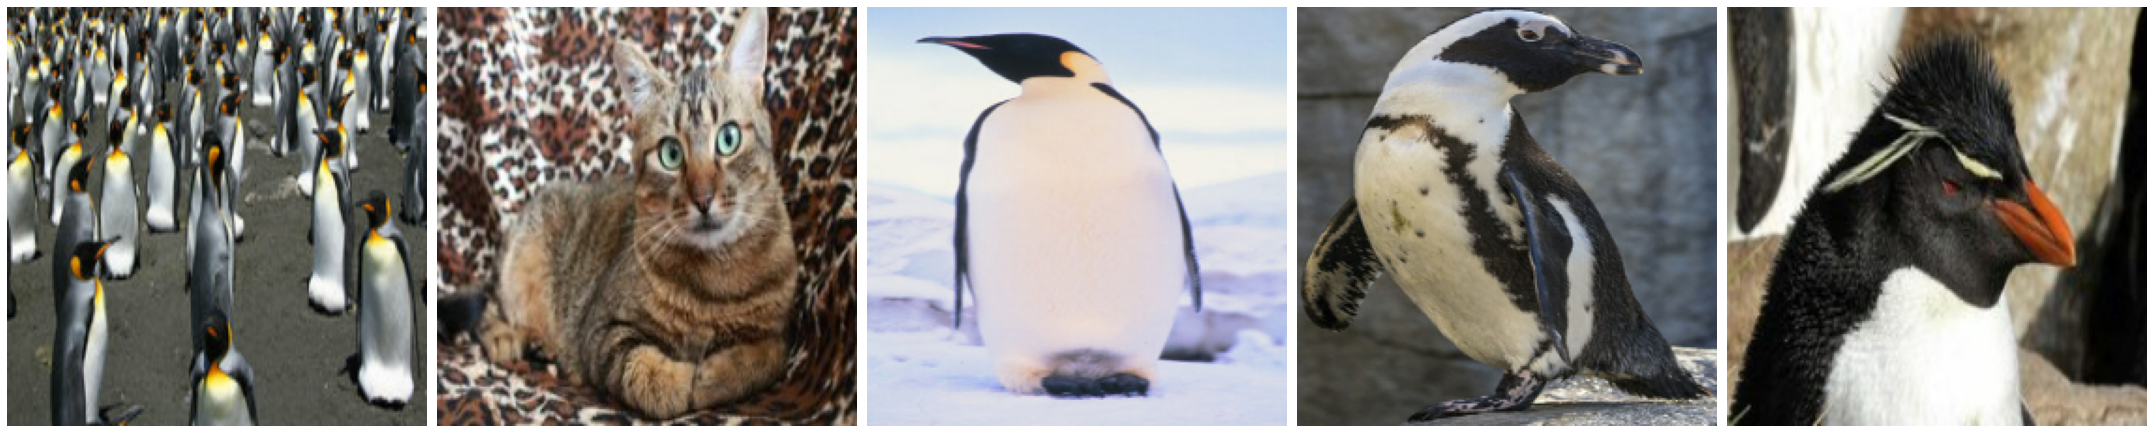

In [4]:
data = keras.preprocessing.image_dataset_from_directory('data',image_size=(224,224),batch_size=5)
img = list(data)[0][0]
display_images(tf.cast(img,tf.int32))

In [4]:
decode_predictions(vgg.predict(preprocess_input(img)))

2022-04-14 18:24:11.806956: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


In [5]:
d = { 0 : [], 1: [] }
for x,y in data:
    xp = preprocess_input(x)
    res = vgg.predict(xp)
    pred = decode_predictions(res,top=1)
    for xi,yi in zip(pred,y):
        d[int(yi)].append(xi[0][1])

print(f"Cats predictions: {','.join(d[0])}\nPenguin predictions: {','.join(d[1])}")

2022-04-14 18:25:16.883169: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


### How VGG works

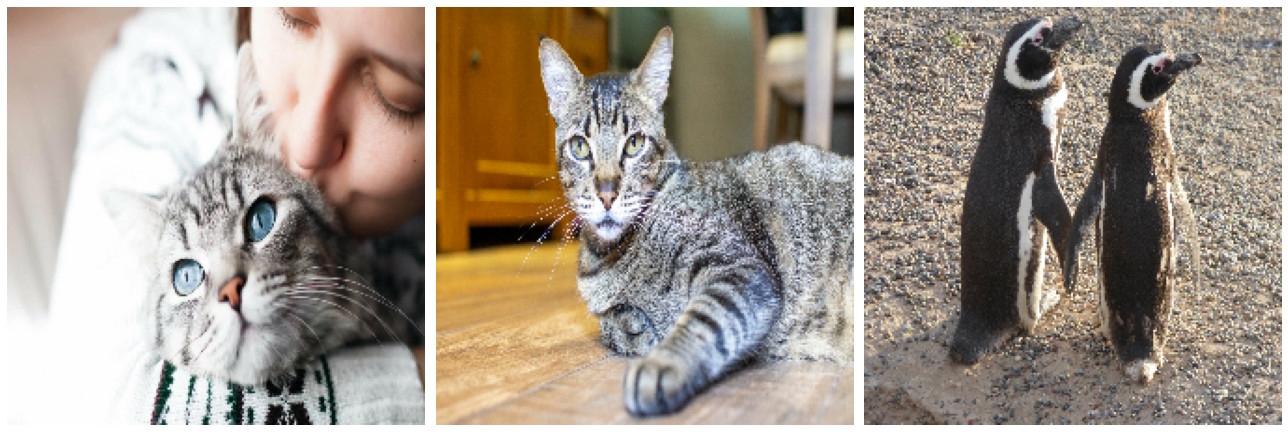

In [27]:
img = list(data)[0][0]
display_images(tf.cast(img,tf.int32))

In [63]:
layers = ['block1_conv1', 'block3_conv2', 'block5_conv3']
layer_outputs = [ vgg.get_layer(n).output for n in layers ]
activation_model = keras.models.Model(inputs=vgg.input, outputs=layer_outputs)
out = activation_model(keras.applications.vgg16.preprocess_input(img))

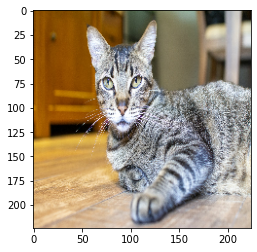

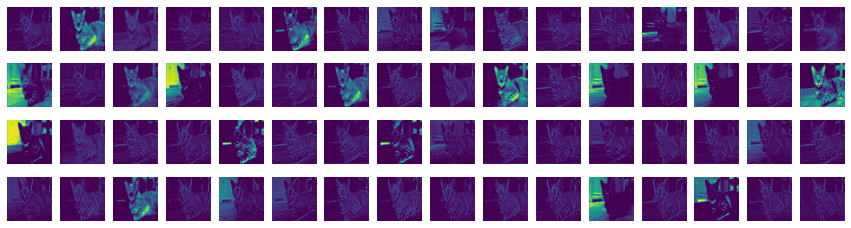

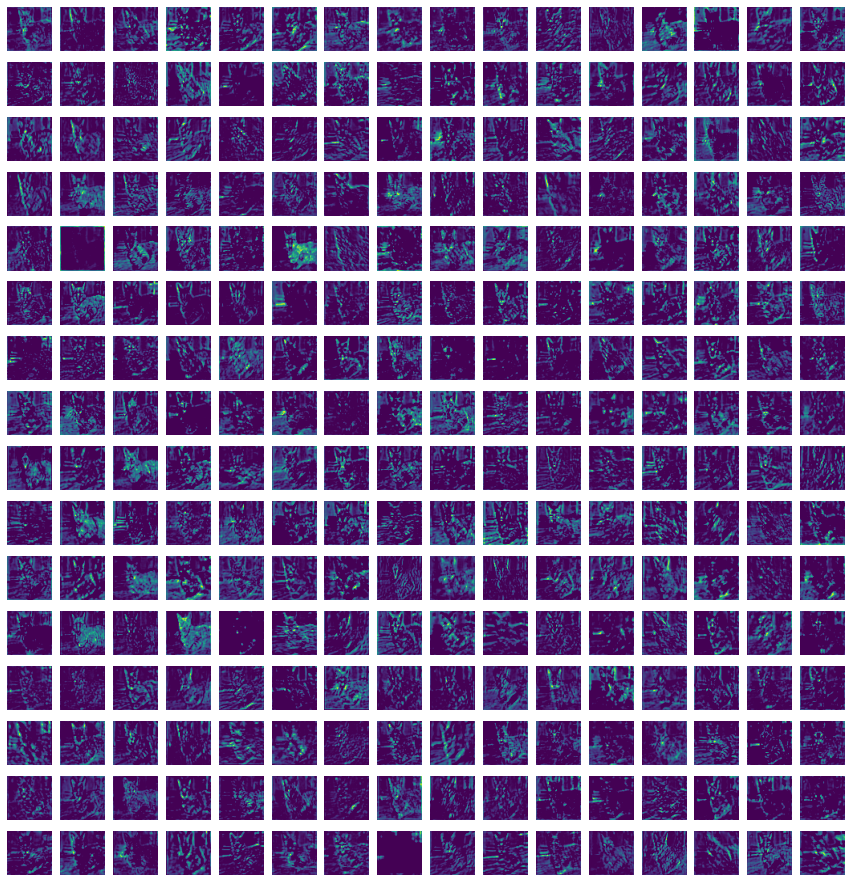

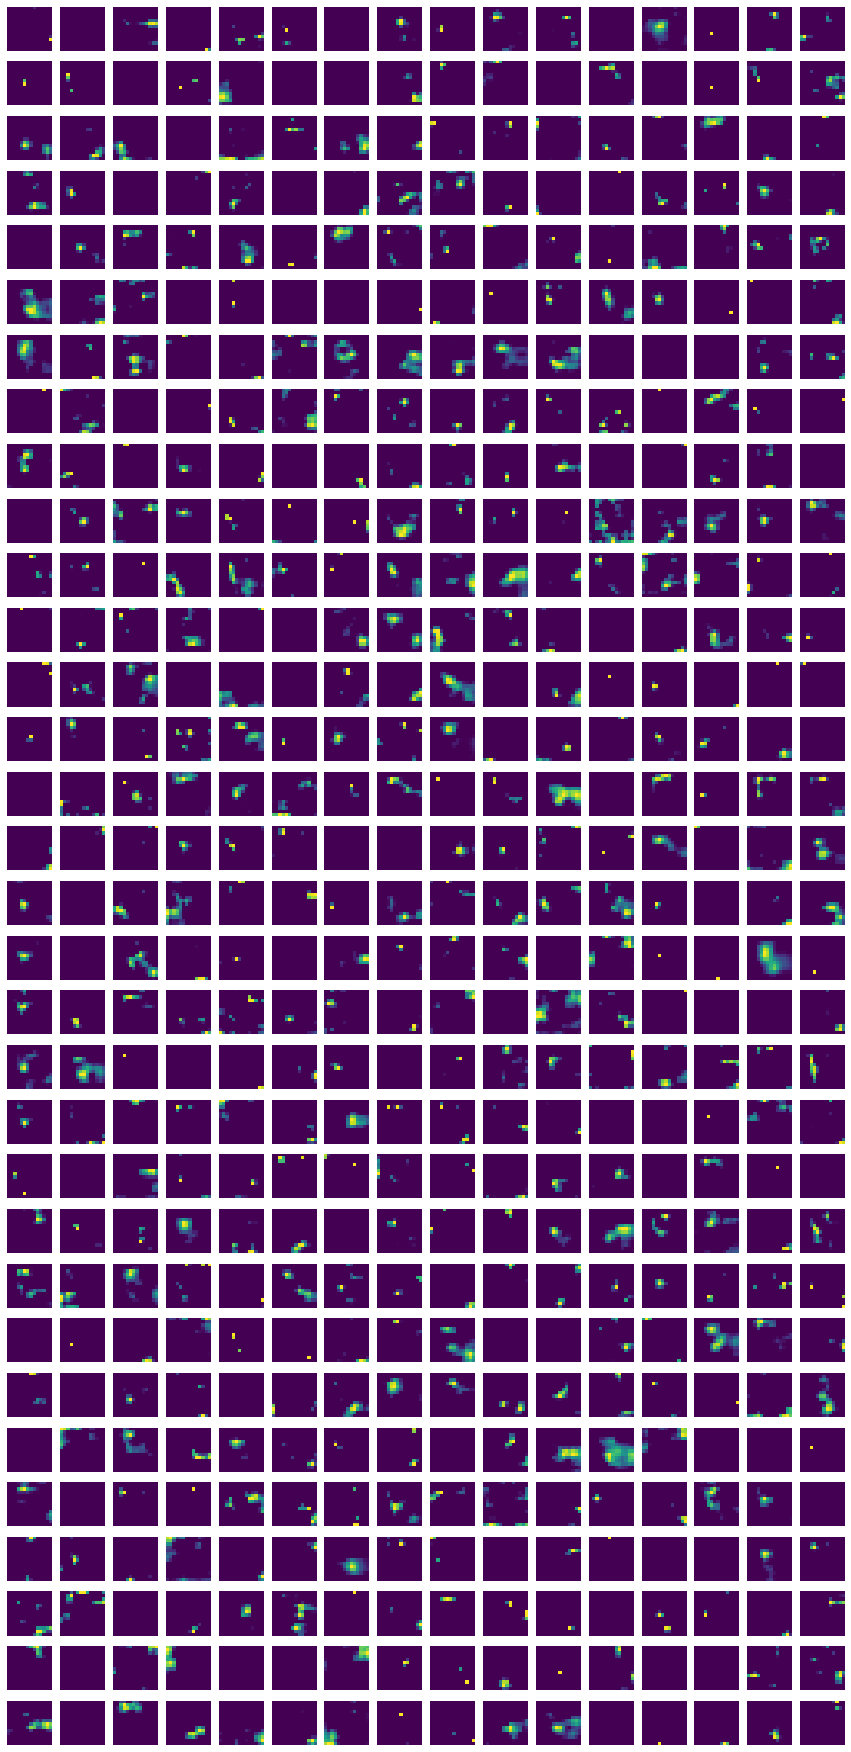

In [64]:
def normalize(img):
    return (img-tf.reduce_min(img))/(tf.reduce_max(img)-tf.reduce_min(img))

n_image = 1
width = 16

plt.imshow(normalize(img[n_image]))

for o in out:
    n_filters = o.shape[-1]
    height = n_filters//width
    fig,ax = plt.subplots(height,width,figsize=(15,height))
    on = normalize(o[n_image])
    for i in range(n_filters):
        ax[i//width,i%width].imshow(on[:,:,i],cmap='viridis')
        ax[i//width,i%width].axis('off')
    plt.show()

KeyboardInterrupt: 

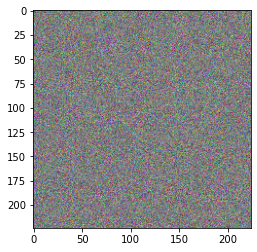

In [70]:
x = tf.Variable(tf.random.normal((1,224,224,3)))
target = [284] # Siamese cat
for i in range(100):
    with tf.GradientTape() as t:
        res = vgg(x)
        loss = tf.reduce_mean(keras.metrics.sparse_categorical_crossentropy(target,res))
        grads = t.gradient(loss,x)
        x.assign_sub(0.01*grads)
        if i%10 == 0:
            plt.imshow(normalize(x[0]))



out

### Does it work at all?

In [10]:
d = { 0 : [], 1: [] }
for x,y in data:
    xp = preprocess_input(x)
    res = vgg.predict(xp)
    pred = decode_predictions(res,top=1)
    for xi,yi in zip(pred,y):
        d[int(yi)].append(xi[0][1])

print(f"Cats predictions: {','.join(d[0])}\nPenguin predictions: {','.join(d[1])}")

Cats predictions: Egyptian_cat,tabby,Siamese_cat,Egyptian_cat,wallaby,Arctic_fox,guinea_pig,tabby,Egyptian_cat,Persian_cat,wallaby,Siamese_cat,Egyptian_cat,Ibizan_hound,tabby,Egyptian_cat,Egyptian_cat,Egyptian_cat,Egyptian_cat,tabby,tabby,tabby,Chihuahua,tabby,Persian_cat,tabby,Egyptian_cat,lynx
Penguin predictions: king_penguin,king_penguin,king_penguin,king_penguin,badger,ram,king_penguin,king_penguin,king_penguin,king_penguin,king_penguin,Egyptian_cat,king_penguin,king_penguin,king_penguin,king_penguin,king_penguin,king_penguin,king_penguin,oystercatcher,king_penguin,king_penguin,red-breasted_merganser,king_penguin,king_penguin,king_penguin,king_penguin


(7, 7, 512)


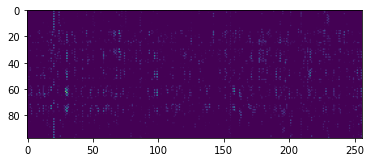

In [24]:
vgg = keras.applications.VGG16(weights='imagenet',include_top=False)

fig,ax = pls.subplots(2)
for x,y in data:
    res = vgg.predict(preprocess_input(x))[0]
    print(res.shape)
    plt.imshow(res.reshape(-1,256))
    break

In [68]:
processed = [(x,vgg.predict(preprocess_input(x)).reshape(-1,7*7*512),y) for x,y in data]
features = tf.concat([f for i,f,y in processed],axis=0)
labels = tf.concat([y for i,f,y in processed],axis=0)
images = tf.concat([i for i,f,y in processed],axis=0)
images = tf.cast(images,tf.int32)

In [69]:
print(features.shape)
print(labels)
print(images.shape)

(55, 25088)
tf.Tensor(
[0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0
 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0], shape=(55,), dtype=int32)
(55, 224, 224, 3)


In [70]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
res = pca.fit_transform(features)

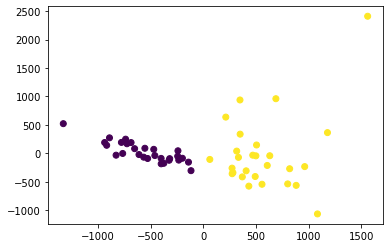

In [71]:
plt.scatter(res[:,0],res[:,1],c=labels)

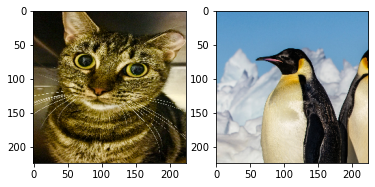

In [72]:
import numpy as np
ix1 = np.argmin(res[:,0])
ix2 = np.argmax(res[:,0])

fig,ax = plt.subplots(1,2)
ax[0].imshow(images[ix1])
ax[1].imshow(images[ix2])

In [84]:
def display_images(ims):
    fig,ax = plt.subplots(1,len(ims),figsize=(20,8))
    for i,im in enumerate(ims):
        ax[i].imshow(im)
        ax[i].axis('off')

11


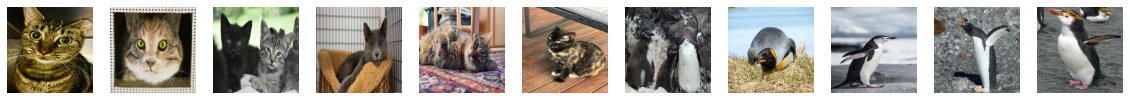

In [85]:
ar = [(im,x[0]) for im,x in zip (images,res)]
ar.sort(key=lambda x:x[1])
print(len(ar[::5]))
display_images([im for im,_ in ar[::5]])